In [1]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display

# Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile

# Import IBM account
from qiskit import IBMQ
import qiskit.tools.jupyter
IBMQ.load_account()
%qiskit_backend_overview

In [24]:
# Generate RB circuits (2Q RB)

# number of qubits
nQ = 2  
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
# Number of seeds (random sequences)
rb_opts['nseeds'] = 5
# Default pattern
rb_opts['rb_pattern'] = [[0,1]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

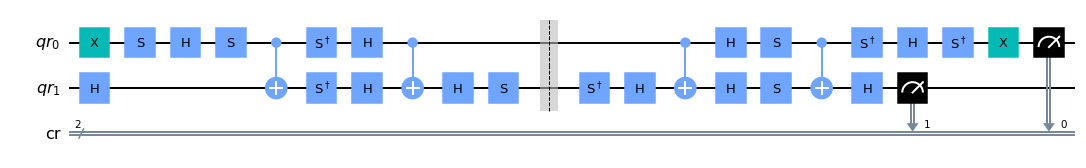

In [25]:
rb_circs[0][0].draw('mpl') #Drawing one of the circuits

In [26]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [29]:
# Create the RB fitter
provider = IBMQ.get_provider(hub='ibm-q')
sim = provider.get_backend('ibm_nairobi')
basis_gates = ['u1','u2','u3','cx'] 
shots = 2048
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs):
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    test = transpile(new_rb_circ_seed,sim)
    job = sim.run(test, shots = shots)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.987622, EPC: 0.009283
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.984266, EPC: 0.011800
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.982903, EPC: 0.012823
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.983646, EPC: 0.012266
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.981351, EPC: 0.013987


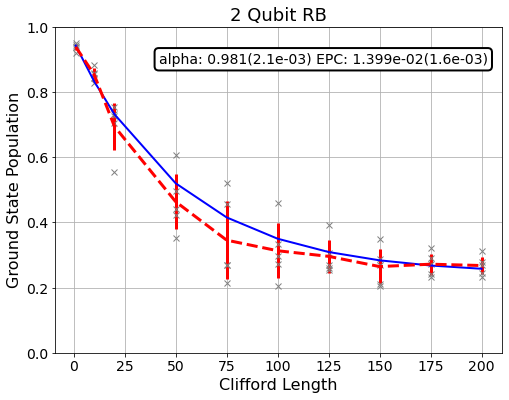

In [32]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)
plt.ylim(0, 1)
plt.savefig('nairobi-2qub.png')
plt.show()